In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df  = pd.read_csv('/content/Gear_Fault_data.csv')

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df.iloc[:,:-2]=scaler.fit_transform(df.iloc[:,:-2])

df

,a1,a2,a3,a4,load,fault
0,0.499253,0.332225,-0.441368,-0.473689,0.0,F
1,0.521014,0.319700,-0.748440,0.226679,0.0,F
2,-0.050550,-0.061641,0.211113,0.139452,0.0,F
3,0.240414,-0.204237,0.185505,0.141112,0.0,F
4,-0.274329,0.223736,-0.299100,-0.080059,0.0,F
...,...,...,...,...,...,...
1084717,4.385437,1.112278,-1.719360,3.442719,0.0,H
1084718,-2.868220,-1.060049,2.943937,0.802508,0.0,H
1084719,0.892001,-0.258394,-0.849360,-0.704612,0.0,H
1084720,3.032652,1.170663,-3.652282,0.755723,0.0,H


**Making the dataset with window length for CNN**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
win_len=100
stride=200

X=[]
Y=[]


for k in ['F','H']:

    df_temp_1 = df[df['fault']==k]

    for j in (np.arange(0,1,0.1)):
        df_temp_2=df_temp_1[df_temp_1['load']==j]

        for i in np.arange(0,len(df_temp_2)-(win_len),stride):
            X.append(df_temp_2.iloc[i:i+win_len,:-1])
            Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [ ]:
X.shape

(3993, 100, 5, 1)

**T-sne dimensionality reduction before CNN**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3993 samples in 0.004s...
[t-SNE] Computed neighbors for 3993 samples in 1.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3993
[t-SNE] Computed conditional probabilities for sample 2000 / 3993
[t-SNE] Computed conditional probabilities for sample 3000 / 3993
[t-SNE] Computed conditional probabilities for sample 3993 / 3993
[t-SNE] Mean sigma: 5.160466
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.969482
[t-SNE] KL divergence after 300 iterations: 3.284017


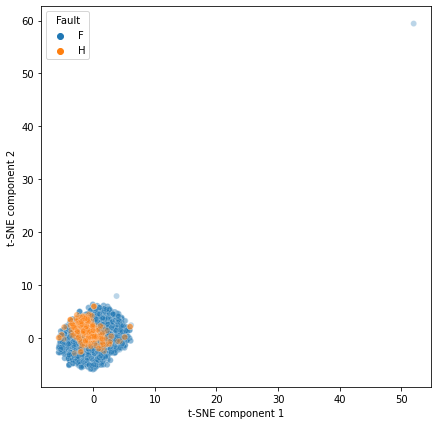

In [ ]:
X_pre_cnn = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_cnn)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=Y


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=
(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

**CNN Model**

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D



# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = 2

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(20, 3),activation='relu',input_shape=(X.shape[1],X.shape[2],1),padding='same'))

cnn_model.add(MaxPooling2D((20, 2),strides=(5, 5),padding='same'))

cnn_model.add(Conv2D(64, (10, 3), activation='relu',padding='same'))

cnn_model.add(MaxPooling2D(pool_size=(10, 2),strides=(3, 3),padding='same'))

# cnn_model.add(Conv2D(128, (5, 3), activation='relu',padding='same'))

# cnn_model.add(MaxPooling2D(pool_size=(5, 2),strides=(3, 3),padding='same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))


cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 5, 32)        1952      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 1, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 1, 64)         61504     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
batch_size = 128
epochs = 5
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/5
22/22 [==============================] - 4s 160ms/step - loss: 0.3143 - accuracy: 0.8694 - val_loss: 0.1802 - val_accuracy: 0.9015
Epoch 2/5
22/22 [==============================] - 3s 148ms/step - loss: 0.0598 - accuracy: 0.9775 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 3/5
22/22 [==============================] - 3s 147ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.1475e-04 - val_accuracy: 1.0000
Epoch 4/5
22/22 [==============================] - 3s 146ms/step - loss: 4.7600e-04 - accuracy: 1.0000 - val_loss: 1.3725e-04 - val_accuracy: 1.0000
Epoch 5/5
22/22 [==============================] - 3s 147ms/step - loss: 2.5252e-04 - accuracy: 1.0000 - val_loss: 1.2222e-04 - val_accuracy: 1.0000


In [ ]:
cnn_model.save(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')

**Performance of the proposed model**

38/38 [==============================] - 1s 15ms/step


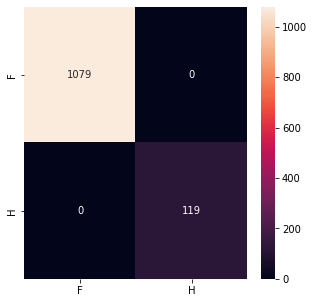

In [ ]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(5,5))
cm = confusion_matrix(Y_test, Y_pred)
f = sns.heatmap(cm, annot=True, fmt='d',xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

**Visualize the output**

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)

88/88 [==============================] - 2s 16ms/step


In [ ]:
y_viz.shape

(2795, 128)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2795 samples in 0.001s...
[t-SNE] Computed neighbors for 2795 samples in 0.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2795
[t-SNE] Computed conditional probabilities for sample 2000 / 2795
[t-SNE] Computed conditional probabilities for sample 2795 / 2795
[t-SNE] Mean sigma: 0.639434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.184177
[t-SNE] KL divergence after 300 iterations: 1.573324


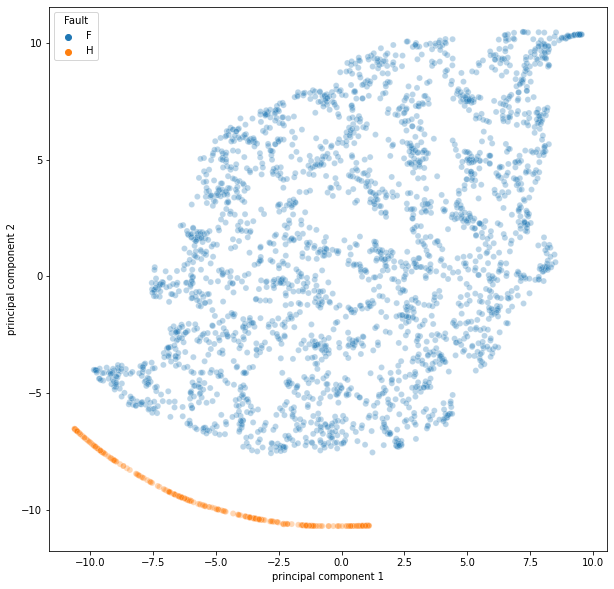

In [ ]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['principal component 1', 'principal component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['principal component 1'],y=tSNEdf['principal component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

**Flatten Layer**

88/88 [==============================] - 2s 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2795 samples in 0.001s...
[t-SNE] Computed neighbors for 2795 samples in 0.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2795
[t-SNE] Computed conditional probabilities for sample 2000 / 2795
[t-SNE] Computed conditional probabilities for sample 2795 / 2795
[t-SNE] Mean sigma: 1.036344
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.610367
[t-SNE] KL divergence after 300 iterations: 1.608810


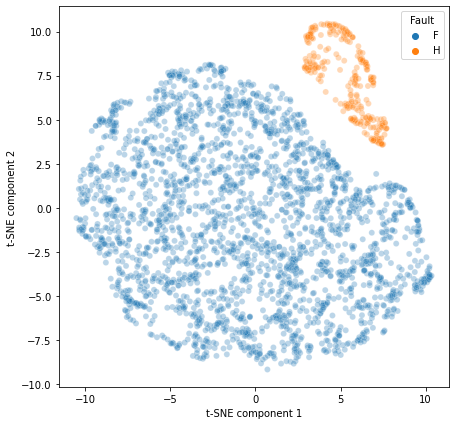

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[4].output)
y_viz = dummy_cnn.predict(X_train)


from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()